In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TrialSolution import TrialSolution

# Example 4

$$\frac{d}{dx}\Psi_1=\cos(x)+\Psi_1^2+\Psi_2-(1+x^2+\sin^2(x))$$
$$\frac{d}{dx}\Psi_2=2x -(1+x^2)\sin(x)+\Psi_1\Psi_2$$

With boundary initial condition $\Psi_1(0)=0$, $\Psi_2(0)=1$ and domain $x\in[0,3]$

In [2]:
def const_function(c):
    def function(X):
        return tf.constant(c, dtype='float64', shape=(X.shape[0],1))
    return function
inits = [{'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':1,
        'function': const_function(0.) },
        {'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':2,
        'function': const_function(1.)}]

In [3]:
X_train = np.arange(0, 3, 0.2) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 3, 0.01) + 1e-8
X_test = X_test.reshape(-1,1)

The trial solutions for the case are $\Psi_1(x)=xN_1(x)$ and $\Psi_1(x)=1+xN_1(x)$.
Though, in our case, the trial solution is generated automatically from the initial conditions.

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_k\sum_i \left(L_k\Psi_k(x_i, N_k(x_i))-f(x_i,\Psi_k(x_i, N_k(x_i)),\Psi_{k'}(x_i, N_{k'}(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [4]:
def diff_loss(network, inputs):
#     print(f'Input shape: {inputs.shape}')
#     print(network(inputs).shape)
    with tf.GradientTape() as tape1: 
        with tf.GradientTape() as tape2:
            inputs = tf.convert_to_tensor(inputs)
            tape1.watch(inputs)
            tape2.watch(inputs)
            response = network(inputs)
            psi1 = tf.reshape(response[:, 0], shape=(inputs.shape[0],1))
            psi2 = tf.reshape(response[:, 1], shape=(inputs.shape[0],1))
    grads1 = tape1.gradient(psi1, inputs)
    grads2 = tape2.gradient(psi2, inputs)
#     print(f'Psi1 shape: {psi1.shape}')
#     print(f'Grads shape: {grads2.shape}')
    loss1 = (grads1 - tf.cos(inputs) - psi1**2 - psi2 + tf.constant(1, dtype='float64')
           + inputs ** 2 + tf.sin(inputs) ** 2)
#     print('loss1', loss1.shape)
    loss2 = (grads2 - 2. * inputs 
           + (1. + inputs**2) * tf.sin(inputs) - psi1*psi2)
#     print('loss2', loss2.shape)
    loss = tf.square(loss1) + tf.square(loss2)
    loss = tf.math.reduce_sum(loss)
#     print('loss', loss.shape, loss)
    return loss

In [5]:
# Call method
def custom_call(self, X):
    X = tf.convert_to_tensor(X)
    responses = []
    for i in range(self.ODE_number):
        resp = self.hidden_layers[i](X)
        responses.append(self.output_layers[i](resp))
    responses[0]*=X
    responses[0]+=0.
    responses[1]*=X
    responses[1]+=1.
    response = tf.concat(responses, axis=1)
    return response

In [19]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1, ODE_number=2, equation_type='ODE_system', call_method=custom_call)

### Training

In [20]:
ts.train(X=X_train, diff_loss=diff_loss, epochs=10000, message_frequency=1000, optimizer_name='SGD', learning_rate=1e-3)

Epoch: 1000 Loss: 1.3838525158011037
Epoch: 2000 Loss: 0.6455528463771869
Epoch: 3000 Loss: 0.5036863110039262
Epoch: 4000 Loss: 0.41077704806664517
Epoch: 5000 Loss: 0.33072515731327645
Epoch: 6000 Loss: 0.25891074151010035
Epoch: 7000 Loss: 0.19651904612520849
Epoch: 8000 Loss: 0.14520363107845635
Epoch: 9000 Loss: 0.10533970272619894
Epoch: 10000 Loss: 0.07586661771127881


### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

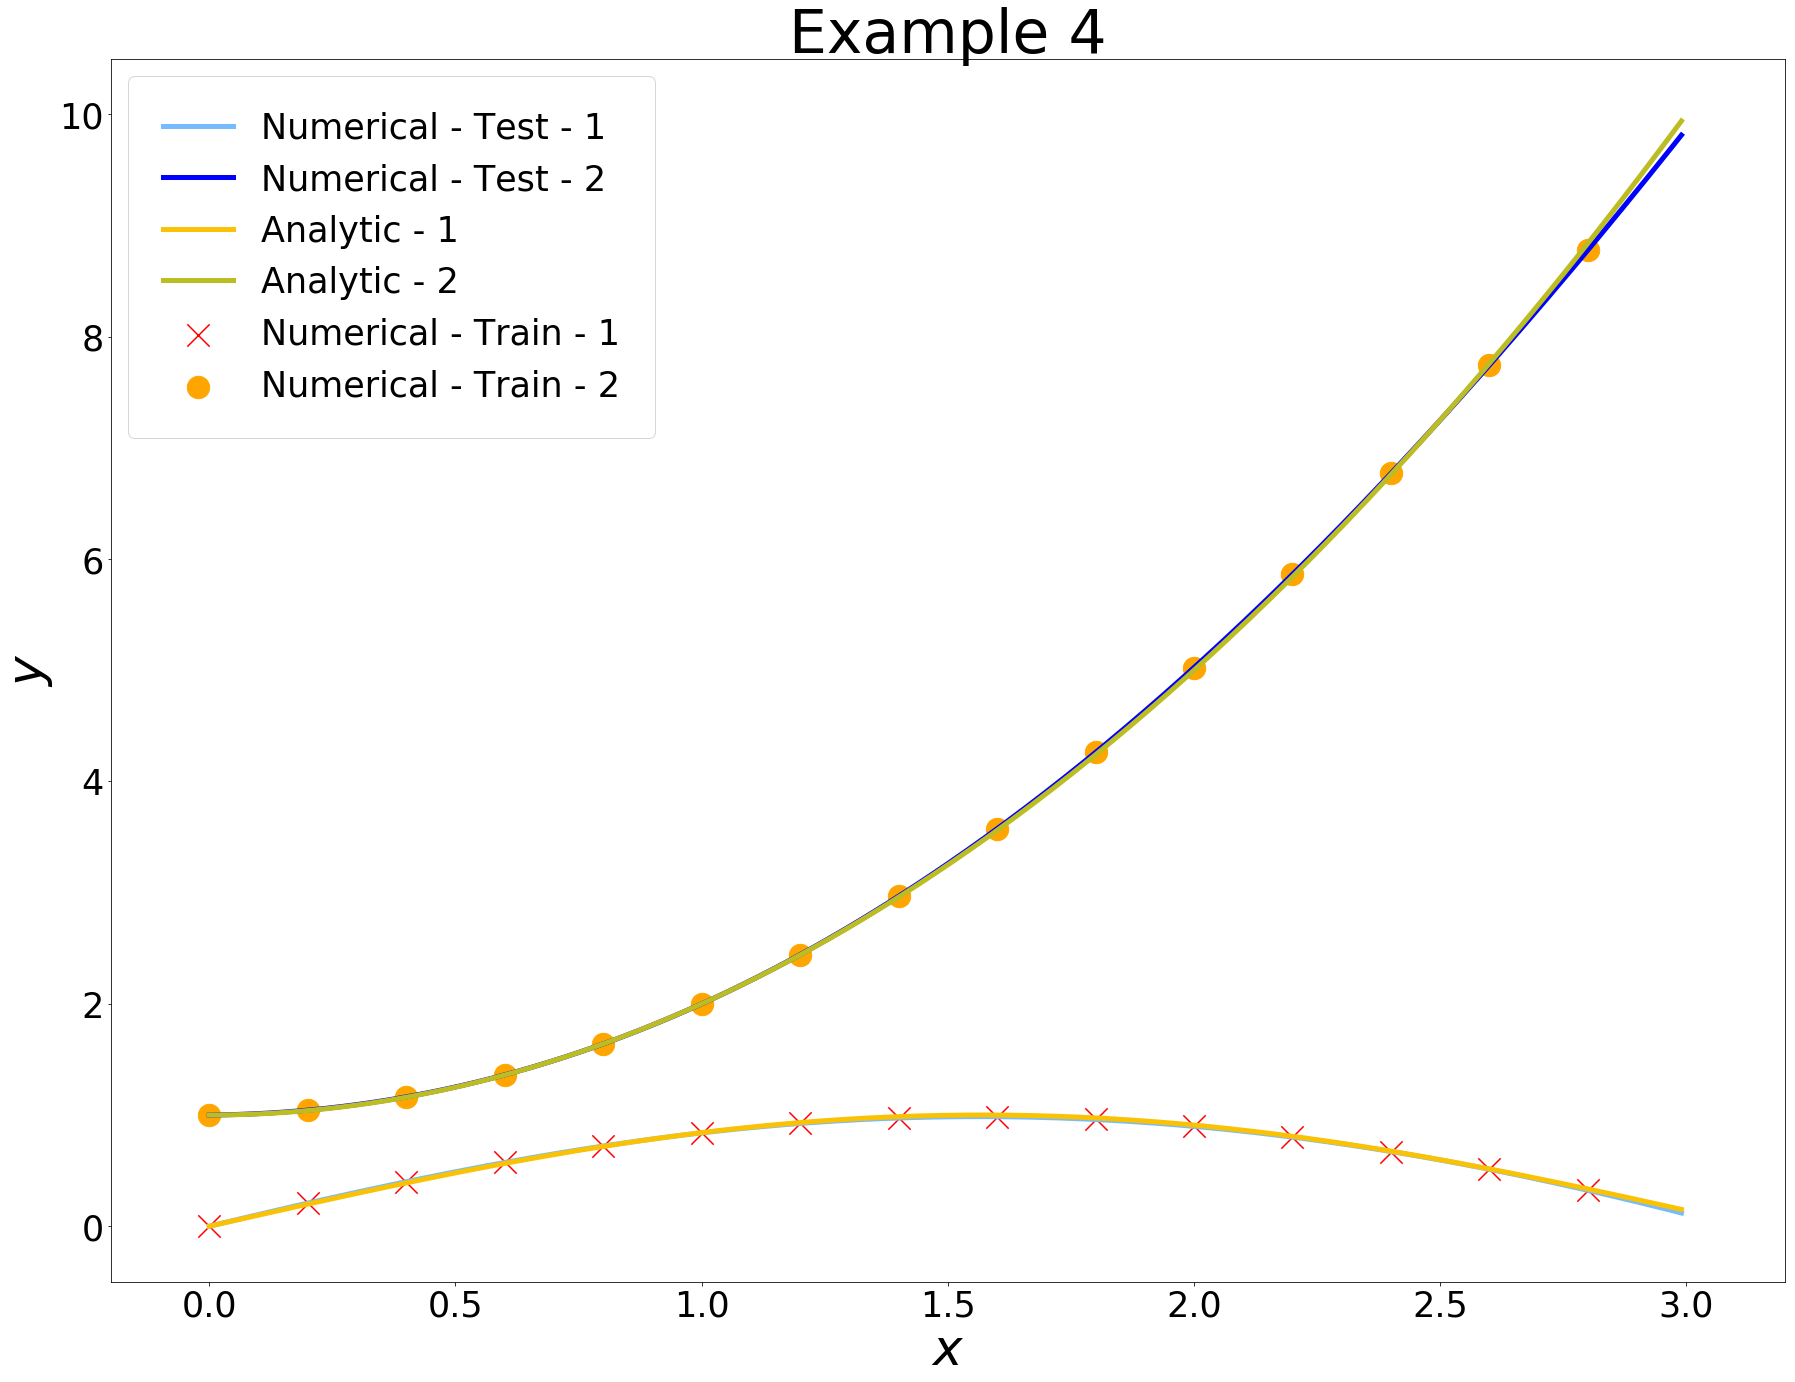

In [21]:
plt.clf()
pred1 = ts(tf.convert_to_tensor(X_train, dtype='float64'))[:, 0].numpy()
pred2 = ts(tf.convert_to_tensor(X_train, dtype='float64'))[:, 1].numpy()
pred1_test = ts(tf.convert_to_tensor(X_test, dtype='float64'))[:, 0].numpy()
pred2_test = ts(tf.convert_to_tensor(X_test, dtype='float64'))[:, 1].numpy()
plt.scatter(X_train, pred1, label='Numerical - Train - 1', marker='x', s=500, c='red')
plt.scatter(X_train, pred2, label='Numerical - Train - 2', marker='o', s=500, c='orange')
plt.plot(X_test, pred1_test, label='Numerical - Test - 1', c='xkcd:sky blue', linewidth=5)
plt.plot(X_test, pred2_test, label='Numerical - Test - 2', c='blue', linewidth=5)
plt.plot(X_test, np.sin(X_test), label='Analytic - 1', c='xkcd:goldenrod', linewidth=5)
plt.plot(X_test, 1+X_test**2, label='Analytic - 2', c='tab:olive', linewidth=5)
plt.xlim((-0.2,3.2))
plt.ylim((-0.5,10.5))
plt.xlabel(r'$x$', fontsize='50')
plt.ylabel(r'$y$', fontsize='50')
plt.title('Example 4', fontsize='60')
plt.gcf().set_size_inches(30, 22.5)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.legend(borderpad=1, fontsize='35')
plt.savefig('plots/example4v2.jpg')
plt.show()

In [10]:
diff1 = pred1_test - np.sin(X_test)
diff2 = pred2_test - (1+X_test**2)

In [11]:
print(np.abs(diff1).mean())
print(np.abs(diff2).mean())

1.51625987114713
4.015476154581511


In [12]:
print(np.abs(diff1).max())
print(np.abs(diff2).max())

3.7365036960346196
11.730986287853899


The errors are suprisingly low for such a short training. The problem arising is that the success of the training procedure relys solely on the lucky initialization. It either converges in a short trainig (10k epochs) or it never converges.